In [5]:
#Sources:
#https://nbviewer.jupyter.org/github/pedvide/ISLR_Python/blob/master/Chapter6_Linear_Model_Selection_and_Regularization.ipynb#6.5.1-Best-Subset-Selection
#https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py
#https://stackoverflow.com/questions/51052587/finding-the-mean-squared-error-for-a-linear-regression-in-python-with-scikit-le
#https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html
#https://datascience.stackexchange.com/questions/60547/hyperparameter-tuning-with-validation-set
#https://gist.github.com/agramfort/1610922

#PART b Stuff
#https://www.statology.org/lasso-regression-in-python/
#https://machinelearningmastery.com/lasso-regression-with-python/


In [6]:
import numpy as np
from numpy import arange
import sklearn as sk
from sklearn import linear_model
from regressors import stats
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

import pandas as pd
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale, StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

import itertools
from itertools import combinations

from sklearn.datasets import load_boston

%matplotlib inline
plt.style.use('seaborn-white')

# a) i) Find most significant features 

In [99]:
boston = load_boston()
#-------------

#Preprocessing
data1 = boston.data #Load data matrix
print(type(boston.data)) #Check type for API compatibility
#Standarized
data1 = data1.tolist() 
scaler = StandardScaler()
scaler.fit(data1)

#Global variables
stand_data = scaler.transform(data1)#Standardized Data
data1 = stand_data #Incase the wrong variable name is used for data later on



#print("Data type stand_data", type(stand_data))
print(type(boston.feature_names[[1,2]]))
print(boston.feature_names[[1,2]])
#print("Data size stand_data", np.shape(stand_data))
y = boston.target #Target data

df = pd.DataFrame(data=stand_data, columns=boston.feature_names)
X = df



<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
['ZN' 'INDUS']


In [ ]:
#Statistical significance in Linear Regression?


In [55]:
#Best subsets function
def best_subsets(estimator, X, y, max_size, cv):
    size_1_case = []
    n_features = X.shape[1]
    subsets = (combinations(range(n_features), k + 1) for k in range(min(n_features, max_size)))

    best_size_subset = []
    for subsets_k in subsets:  # for each list of subsets of the same size
        best_score = -np.inf
        best_subset = None
        for subset in subsets_k:  # for each subset
            estimator.fit(X.iloc[:, list(subset)], y)
            # get the subset with the best score among subsets of the same size
            score = estimator.score(X.iloc[:, list(subset)], y)
            if np.size(subset) ==1:
                
                size_1_case.append(score)
                
            if score > best_score:
                best_score, best_subset = score, subset
        # to compare subsets of different sizes we must use CV
        # first store the best subset of each size
        best_size_subset.append(best_subset)

    # compare best subsets of each size
    best_score = -np.inf
    best_subset = None
    list_scores = []
    for subset in best_size_subset:
        score = cross_val_score(estimator, X.iloc[:, list(subset)], y, cv=cv).mean()
        list_scores.append(score)
        if score > best_score:
            best_score, best_subset = score, subset

    return size_1_case, best_subset, best_score, best_size_subset, list_scores

In [56]:
lm = LinearRegression()
#best_subsets(lm, X, y, max_size=3, cv=5)
size_1_case, best_subset, best_score, best_size_subset, list_scores = best_subsets(lm, X, y, max_size=5, cv=10)

In [62]:
#Results for Best Subsets
#(Best subsets size 1 as used Linear Reg as estimator)
for subset in best_size_subset:
    print(len(subset), X.columns[list(subset)].values)
    


1 ['LSTAT']
2 ['RM' 'LSTAT']
3 ['RM' 'PTRATIO' 'LSTAT']
4 ['RM' 'DIS' 'PTRATIO' 'LSTAT']
5 ['NOX' 'RM' 'DIS' 'PTRATIO' 'LSTAT']


In [65]:
#Results for Statistical signifcance in Linear Regression
coef = size_1_case
coef_ref = size_1_case

coef.sort()
coef = np.flip(coef)
#Show n largest non-zero 
n = 13
best_features = []
best_features_indx = []
indicies = list(range(np.size(coef)))
for i in indicies:
    if np.size(best_features) < n and abs(coef[i]) != 0:
        
        best_features.append((boston.feature_names[coef_ref.index(coef[i])]))
        best_features_indx.append(coef_ref.index(coef[i]))
    

print("Statistical signifcance in Linear Regression (Sorted from most to least significant) ", best_features)
#print(best_features_indx)

Statistical signifcance in Linear Regression (Sorted from most to least significant)  ['LSTAT', 'B', 'PTRATIO', 'TAX', 'RAD', 'DIS', 'AGE', 'RM', 'NOX', 'CHAS', 'INDUS', 'ZN', 'CRIM']


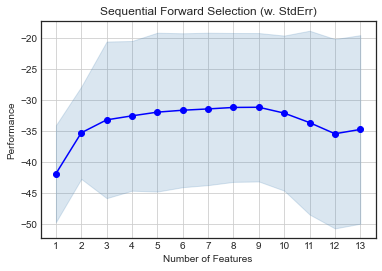


Sequential Forward Selection:
['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT']
CV Score:
-31.129864192071654


In [20]:
#Resutls for Stepwise Feature selection forwards
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

lr = LinearRegression()

sfs = SFS(lr, 
          k_features=(1,len(X.columns)), 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sfs = sfs.fit(X.values, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

print('\nSequential Forward Selection:')
print(X.columns[list(sfs.k_feature_idx_)].tolist())
print('CV Score:')
print(sfs.k_score_)

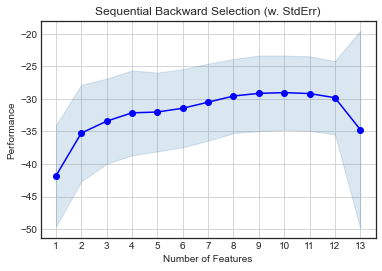


Sequential Backward Selection:
['CRIM', 'ZN', 'NOX', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
CV Score:
-29.024769214181912


In [21]:
#Backwards stepwise selection
lr = LinearRegression()
sbs = SFS(lr, 
          k_features=(1,len(X.columns)), 
          forward=False, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sbs = sbs.fit(X.values, y)
fig = plot_sfs(sbs.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

print('\nSequential Backward Selection:')
print(X.columns[list(sbs.k_feature_idx_)].tolist())
print('CV Score:')
print(sbs.k_score_)

In [22]:
#Lasso basic
clf = linear_model.Lasso(alpha=0.1)
clf.fit(data1,y)


#Displaying Results-------------------------------------------------
coef = abs(clf.coef_)
coef_ref = abs(clf.coef_)
coef.sort()
coef = np.flip(coef)
#Show n largest non-zero 
n = 10
best_features = []
best_features_indx = []
indicies = list(range(np.size(coef)))
for i in indicies:
    if np.size(best_features) < n and abs(coef[i]) != 0:
        
        best_features.append((boston.feature_names[coef_ref.tolist().index(coef[i])]))
        best_features_indx.append(coef_ref.tolist().index(coef[i]))
    

print(best_features)
print(best_features_indx)

['LSTAT', 'RM', 'DIS', 'PTRATIO', 'NOX', 'RAD', 'TAX', 'B', 'ZN', 'CHAS']
[12, 5, 7, 10, 4, 8, 9, 11, 1, 3]


In [23]:
#LassoCV version
lasscv = LassoCV(cv=5, random_state=0).fit(data1, y)
#print(lasscv.coef_)

#Displaying Results-------------------------------------------------
coef = abs(lasscv.coef_)
coef_ref = abs(lasscv.coef_)
coef.sort()
coef = np.flip(coef)
#Show n largest non-zero 
n = 10
best_features = []
best_features_indx = []
indicies = list(range(np.size(coef)))
for i in indicies:
    if np.size(best_features) < n and abs(coef[i]) != 0:
        
        best_features.append((boston.feature_names[coef_ref.tolist().index(coef[i])]))
        best_features_indx.append(coef_ref.tolist().index(coef[i]))
    

print(best_features)
print(best_features_indx)

['LSTAT', 'RM', 'DIS', 'PTRATIO', 'NOX', 'B', 'CHAS', 'ZN', 'CRIM', 'RAD']
[12, 5, 7, 10, 4, 11, 3, 1, 0, 8]


In [24]:
#Elastic Net
regr = ElasticNetCV(random_state=0)
regr.fit(data1, y)
#ElasticNet(random_state=0)
#print(regr.coef_)



#Displaying Results-------------------------------------------------
coef = abs(regr.coef_)
coef_ref = abs(regr.coef_)
coef.sort()
coef = np.flip(coef)
#Show n largest non-zero 
n = 10
best_features = []
best_features_indx = []
indicies = list(range(np.size(coef)))
for i in indicies:
    if np.size(best_features) < n and abs(coef[i]) != 0:
        
        best_features.append((boston.feature_names[coef_ref.tolist().index(coef[i])]))
        best_features_indx.append(coef_ref.tolist().index(coef[i]))
    

print(best_features)
print(best_features_indx)

['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'B', 'CHAS', 'CRIM', 'RAD', 'ZN']
[12, 5, 10, 7, 4, 11, 3, 0, 8, 1]


In [25]:
#Adaptive Lasso
lasscv = LassoCV(cv=5, random_state=0).fit(X, y)
weights = (1/lasscv.coef_) #This seems weird, check with TAs
weights_adj = []
for i in weights: 
    if abs(i) >1000000000000000:
        weights_adj.append(0)
    else:
        weights_adj.append(i)
        
#print(weights_adj)

#scale columns of X by weights
x_lass_scaled_trans = []
data1_trans = np.transpose(data1) #transpose for sake of python row major
indx_lst = list(range(np.size(weights_adj)))
for indx in indx_lst:
    scaled = data1_trans[indx]*weights_adj[indx]
    x_lass_scaled_trans.append(scaled)
    
    
x_lass_scaled = np.transpose(x_lass_scaled_trans)

#run lasso again for adaptive
lasscv_adpt = LassoCV(cv=5, random_state=0).fit(x_lass_scaled, y)
#print(lasscv_adpt.coef_)

#Displaying Results-------------------------------------------------
coef = abs(lasscv_adpt.coef_)
coef_ref = abs(lasscv_adpt.coef_)

coef.sort()
coef = np.flip(coef)
#Show n largest non-zero 
n = 10
best_features = []
best_features_indx = []
indicies = list(range(np.size(coef)))
for i in indicies:
    if np.size(best_features) < n and abs(coef[i]) != 0:
        
        best_features.append((boston.feature_names[coef_ref.tolist().index(coef[i])]))
        best_features_indx.append(coef_ref.tolist().index(coef[i]))
    

print(best_features)
print(best_features_indx)

['LSTAT', 'RM', 'DIS', 'PTRATIO', 'NOX', 'RAD', 'B', 'ZN', 'CHAS', 'CRIM']
[12, 5, 7, 10, 4, 8, 11, 1, 3, 0]


<ipython-input-25-5a9f55d3c69b>:3: RuntimeWarning: divide by zero encountered in true_divide
  weights = (1/lasscv.coef_) #This seems weird, check with TAs


In [26]:
#print(data1[0:1])
#x_lass_scaled = np.transpose(data1)
#print(np.shape(x_lass_scaled))
#print(np.shape(data1))


In [27]:
# # norm of coefs
# norm_coefs = linalg.norm(coefs, axis=1)
# norm_coefs_line = plt.plot(alphas, norm_coefs)
# plt.plot(alphas, coefs)
# plt.xscale('log')
# plt.xlabel('alpha')
# plt.ylabel('Norm of Ridge coefficients');
# plt.legend(norm_coefs_line, ['Total norm']);


# a) ii) Regularization paths

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


(-1.0478863849541162,
 1.5898476245851252,
 -4.063764386618658,
 3.3351181022873235)

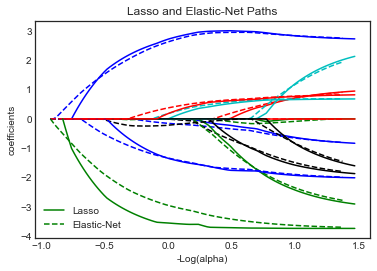

In [28]:
#ii Regularization paths
#Source: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py

from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets
from itertools import cycle 

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, fit_intercept=False)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X, y, eps=eps, positive=True, fit_intercept=False)
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

# Display results

plt.figure(1)
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')


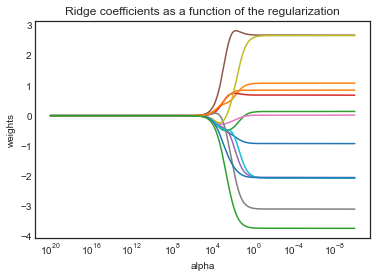

In [29]:
#Regularization path Ridge
#Source: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py
#IDK what else to do for this lol

n_alphas = 2000
alphas = np.logspace(-10, 20, n_alphas)

coefs = []
for a in alphas:
    # Evaluate the models using crossvalidation
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# a) iii) 

 Reflect on these results. Are the top features different for each method? Why or why not? If there are tuning parameters, how did you determine these? Do different tuning parameters yield different important features? Are there any features consistently selected by all methods? What are the most important features and how did you determine this? Explain and expand on your responses.



# b) i)

In [30]:
#b) Split data
from sklearn.model_selection import train_test_split
#Split into 80% for train and val set, 20% for testing
x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=2)
#Split the 80% to 60% train and 20% validation (comes out to 1/4 for validation)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=.25, random_state=3)


In [81]:
print(type(x_train))
print(x_train
     )

<class 'pandas.core.frame.DataFrame'>
         CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
290 -0.416442  2.945843 -0.902709 -0.272599 -1.241285  0.821124 -1.446423   
124 -0.409056 -0.487722  2.117615 -0.272599  0.227231 -0.577891  0.968140   
487  0.142225 -0.487722  1.015999 -0.272599  0.244507 -0.540849 -0.546740   
476  0.146384 -0.487722  1.015999 -0.272599  0.512296  0.284028  0.889907   
75  -0.409448 -0.487722  0.247057 -0.272599 -1.016689  0.001946 -0.838337   
..        ...       ...       ...       ...       ...       ...       ...   
46  -0.398597 -0.487722 -0.616727 -0.272599 -0.921667 -0.710384 -1.254396   
378  2.331500 -0.487722  1.015999 -0.272599  1.004680  0.135863  0.982364   
472 -0.005219 -0.487722  1.015999 -0.272599  0.218592  0.217069  0.228480   
265 -0.331885  0.370669 -1.045700 -0.272599  0.797361 -1.032357 -0.205359   
454  0.686614 -0.487722  1.015999 -0.272599  1.367490  0.631645  0.907687   

          DIS       RAD       TAX   P

In [39]:
#Prediction MSE of L.S regression
#Note that there aren't any hyper parameters thus the validation set is not used

#Source: https://stackoverflow.com/questions/51052587/finding-the-mean-squared-error-for-a-linear-regression-in-python-with-scikit-le
lm = linear_model.LinearRegression()
model = lm.fit(x_train, y_train)
predictions_test = lm.predict(x_test)
predictions_train = lm.predict(x_train)
#MSE
N = len(y_test)
rmse_test = np.sqrt(np.sum((np.array(y_test).flatten() - np.array(predictions_test).flatten())**2)/N)
print("RMSE TEST: ", rmse_test)

#mseV2
rmse_test2 = sk.metrics.mean_squared_error(y_test,predictions_test)
print("RMSE TEST2: ", rmse_test2)

RMSE TEST:  4.41876637319769
RMSE TEST2:  19.525496260902667


In [32]:
#Prediction MSE of Ridge Regression
#If needed, do grid search (need help with this)
#Read somewhere that if no alpha is selected, alphas are automatically iterated over to find best and then returned as model.alpha_


#Iteration method
N = len(y_val)
alphas = [0.000001, 0.001, 0.01, 0.1, 1, 10, 100,1000,10000,100000]
mse_best1 = 1000000000000000000000000000 #Works because of dataset 
mse_best2 = 1000000000000000000000000000 #Works because of dataset 
best_model1 = linear_model.Ridge(alpha=1) #Place holder, idk if this needs to be initialized
best_model2 = linear_model.Ridge(alpha=1) 
for alpha_select in alphas:
    lm = linear_model.Ridge(alpha=alpha_select)
    model = lm.fit(x_train, y_train)
    predictions_val = model.predict(x_val)
    predictions_train = model.predict(x_train)
    mse1 = sk.metrics.mean_squared_error(y_val,predictions_val)
    mse2 = np.sqrt(np.sum((np.array(y_val).flatten() - np.array(predictions_val).flatten())**2)/N)
    #Update best mse option
    if mse1 < mse_best1:
        mse_best1 = mse1
        best_model1 = model
    if mse2 < mse_best2:
        mse_best2 = mse2
        best_model2 = model
    
    
    
print("iterated Ridge MSE results:")
print("MSE1", mse_best1, "MSE2", mse_best2)

#Apply best model on test set
predictions_test = best_model1.predict(x_test)
msefinal1 = sk.metrics.mean_squared_error(y_test,predictions_test)
msefinal2 = np.sqrt(np.sum((np.array(y_test).flatten() - np.array(predictions_test).flatten())**2)/N)

print("MSE1 final", msefinal1)
print("MSE2 final", msefinal2)


# #Example for late below is for alpha = 1.0, but need to utilized validation set to optimize it???? Question for TAs
# lm = linear_model.Ridge(alpha=1.0)
# model = lm.fit(x_train, y_train)
# #print(model.score(x_test, y_test))

# predictions_test = model.predict(x_test)
# predictions_train = model.predict(x_train)





# #MSE
# #Version 1
# #print(sk.metrics.mean_squared_error(y_test,predictions_test),"MSE")
# #Version 2
# N = len(y_test)
# rmse_test = np.sqrt(np.sum((np.array(y_test).flatten() - np.array(predictions_test).flatten())**2)/N)
# #print("RMSE TEST: ", rmse_test)

iterated Ridge MSE results:
MSE1 27.719970403904966 MSE2 5.2649758217778135
MSE1 final 19.32679710462337
MSE2 final 4.417935211317818


In [100]:
#Average prediction MSE Best Subsets (might depend on previous selection)
#What do I use as the predictor? Does it want me to choose the best size 
#subset combo using a L.S estimator and then show the MSE for that?


#Approach 1
#Use results from 1a 
#print(best_size_subset)
#Results: [(12,), (5, 12), (5, 10, 12), (5, 7, 10, 12), (4, 5, 7, 10, 12)]
#Will use top 3 
#Train model only using feature 12, (5,12), and (5,10,12)
lm1 = LinearRegression()
lm2 = LinearRegression()
lm3 = LinearRegression()
df = pd.DataFrame(data=stand_data, columns=boston.feature_names)
print("type", type(data1[:,12]))
subdata1 = pd.DataFrame(data = data1[:,12], columns=boston.feature_names[[12]])

subdata2 = pd.DataFrame(data = data1[:,[5,12]], columns=boston.feature_names[[5,12]])
subdata3 = pd.DataFrame(data = data1[:,[5,10,12]], columns=boston.feature_names[[5,10,12]])

model1 = lm1.fit(subdata1, y)
model2 = lm2.fit(subdata2, y)
model3 = lm3.fit(subdata3, y)
#in progress




type <class 'numpy.ndarray'>


In [34]:
#Average prediction MSE Stepwise 
#['LSTAT', 'B', 'PTRATIO', 'TAX', 'RAD', 'DIS', 'AGE', 'RM', 'NOX', 'CHAS', 'INDUS', 'ZN', 'CRIM']
#Should do worse than best subsets
#['LSTAT']
#['LSTAT', 'B']
#['LSTAT', 'B', 'PTRATIO']


In [35]:
#Average prediction MSE Lasso
#IDK what I'm doing hahahahha help pls
#Looks like we give a list of alphas and it used the best one?

from sklearn.linear_model import LassoCV


N = len(y_val)
alphas = [0.000001, 0.001, 0.01, 0.1, 1, 10, 100,1000,10000,100000]
mse_best1 = 1000000000000000000000000000 #Works because of dataset 
mse_best2 = 1000000000000000000000000000 #Works because of dataset 
best_model1 = linear_model.Lasso(alpha=1) #Place holder, idk if this needs to be initialized
best_model2 = linear_model.Lasso(alpha=1) #Place holder, idk if this needs to be initialized
for alpha_select in alphas:
    lm = linear_model.Lasso(alpha=alpha_select)
    model = lm.fit(x_train, y_train)
    predictions_val = model.predict(x_val)
    predictions_train = model.predict(x_train)
    mse1 = sk.metrics.mean_squared_error(y_val,predictions_val)
    mse2 = np.sqrt(np.sum((np.array(y_val).flatten() - np.array(predictions_val).flatten())**2)/N)
    #Update best mse option
    if mse1 < mse_best1:
        mse_best1 = mse1
        best_model1 = model
    if mse2 < mse_best2:
        mse_best2 = mse2
        best_model2 = model
    
    
    
print("iterated Ridge MSE results:")
print("MSE1", mse_best1, "MSE2", mse_best2)

#Apply best model on test set
predictions_test = best_model1.predict(x_test)
msefinal1 = sk.metrics.mean_squared_error(y_test,predictions_test)
msefinal2 = np.sqrt(np.sum((np.array(y_test).flatten() - np.array(predictions_test).flatten())**2)/N)

print("MSE1 final", msefinal1)
print("MSE2 final", msefinal2)



#---------------------------------------------------------------------------------

cv = RepeatedKFold(n_splits=100, n_repeats=30, random_state=10)
model = LassoCV(cv=5)
model.fit(x_train, y_train)
#print(model.mse_path_)
#print(model.alpha_)
#print(np.min(model.mse_path_))




iterated Ridge MSE results:
MSE1 27.110365951436386 MSE2 5.206761560839557
MSE1 final 19.382115860781635
MSE2 final 4.424253383116421


LassoCV(cv=5)

In [36]:
#Average prediction MSE Elastic Net
regr = ElasticNet(alpha = 1)
regr.fit(data1, y)
N = len(y_val)
alphas = [0.000001, 0.001, 0.01, 0.1, 1, 10, 100,1000,10000,100000]
mse_best1 = 1000000000000000000000000000 #Works because of dataset 
mse_best2 = 1000000000000000000000000000 #Works because of dataset 
best_model1 = linear_model.ElasticNet(alpha=1) #Place holder, idk if this needs to be initialized
best_model2 = linear_model.ElasticNet(alpha=1) #Place holder, idk if this needs to be initialized
for alpha_select in alphas:
    lm = linear_model.ElasticNet(alpha=alpha_select)
    model = lm.fit(x_train, y_train)
    predictions_val = model.predict(x_val)
    predictions_train = model.predict(x_train)
    mse1 = sk.metrics.mean_squared_error(y_val,predictions_val)
    mse2 = np.sqrt(np.sum((np.array(y_val).flatten() - np.array(predictions_val).flatten())**2)/N)
    #Update best mse option
    if mse1 < mse_best1:
        mse_best1 = mse1
        best_model1 = model
    if mse2 < mse_best2:
        mse_best2 = mse2
        best_model2 = model
    
    
    
print("iterated Ridge MSE results:")
print("MSE1", mse_best1, "MSE2", mse_best2)

#Apply best model on test set
predictions_test = best_model1.predict(x_test)
msefinal1 = sk.metrics.mean_squared_error(y_test,predictions_test)
msefinal2 = np.sqrt(np.sum((np.array(y_test).flatten() - np.array(predictions_test).flatten())**2)/N)

print("MSE1 final", msefinal1)
print("MSE2 final", msefinal2)

iterated Ridge MSE results:
MSE1 27.167755651038938 MSE2 5.212269721631732
MSE1 final 19.342198884354065
MSE2 final 4.419695216188684


In [37]:
#Average prediction MSE Adaptive Lasso
#Adaptive Lasso

##echos the Lasso above
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#lasscv = LassoCV(alphas=arange(0.00001, 1, 0.01), cv=5)
#lasscv.fit(data1, y)

lasscv = LassoCV(cv=5, random_state=0).fit(X, y)
weights = (1/lasscv.coef_)
weights_adj = []


for i in weights: 
    if abs(i) >1000000000000000:
        weights_adj.append(0)
    else:
        weights_adj.append(i)
        
#print(weights_adj)

#scale columns of X by weights
x_lass_scaled_trans = []
data1_trans = np.transpose(data1) #transpose for sake of python row major
indx_lst = list(range(np.size(weights_adj)))
for indx in indx_lst:
    scaled = data1_trans[indx]*weights_adj[indx]
    x_lass_scaled_trans.append(scaled)
    
    
x_lass_scaled = np.transpose(x_lass_scaled_trans)

#run lasso again for adaptive
lasscv_adpt = LassoCV(cv=5, random_state=0).fit(x_lass_scaled, y)

#MSE
print("Best Alpha", lasscv_adpt.alpha_)
print("lowest MSE", np.min(lasscv_adpt.mse_path_))

Best Alpha 0.06005821022047542
lowest MSE 9.848113395386973


<ipython-input-37-8d5e3603e1a2>:10: RuntimeWarning: divide by zero encountered in true_divide
  weights = (1/lasscv.coef_)


# b) ii)

Visualize the results of your comparisons. You can choose to only show the results with the
best tuning parameter values.

# b) iii)

Reflection. Which types of methods give the best prediction error? Why do these methods
perform well? Do any methods seem to overfitt to the training set? If so, why? Do all the
methods that give similar predictions choose the same subset of variables? Which is the
overall best method for prediction on this dataset? Explain and expand on your responses.

In [ ]:
## All methods should do about the same as they are all just variations of the same linear model